In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Understanding shapes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

2022-03-13 17:17:57.687505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 17:17:57.687542: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


observe that, besides `batch_shape` distributions have an associated `event_shape`, which in this case in empty, signalling that each distribution in the batch is a distribution of scalars.

In [9]:
d = tfd.Normal(loc=[-1,0], scale=1)
d

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

in general, picture yourself wanting to assigned **different distributions** to **different data points** in your datset.

## Multivariate distributions 

They have `event_shape`. For instance, for a multivariate normal distribution we must specify a covariance matrix. Observe that **this cannot be done** using uniquely the `batch_size`, since in general variables of a multivariate normal **are not independant**

In [21]:
# Initialize a single 3-variate Gaussian.
mu = [1., 2]
cov = [[ 0.36,  0.12],
       [ 0.12,  0.29]]

mvn = tfd.MultivariateNormalTriL(
    loc=mu,
    scale_tril=tf.linalg.cholesky(cov))

In [29]:
s = mvn.sample(10000)
s.shape

TensorShape([10000, 2])

observe that dependance shows as a slanted plot

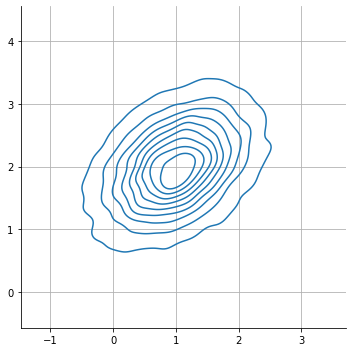

In [28]:
sns.displot( x = s[:,0], y = s[:,1], kind="kde", rug=False)
plt.axis("equal"); plt.grid();

observe that this implies an `event_shape` 

In [33]:
mvn

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

## Combining `batch_shape` and `event_shape`

altogether both determine the sample sizes. Observe how we use broadcasting of the covariance matrix to have a batch of three multivariate distributions of two variables each. The three distributions have the same covariance matrix.

In [147]:
# Initialize a single 3-variate Gaussian.
mu = [[1., 2],[3,4], [5,6]]

cov = [[ 0.36,  0.12],
       [ 0.12,  0.29]]

mvn = tfd.MultivariateNormalTriL(
    loc=mu,
    scale_tril=tf.linalg.cholesky(cov)
)

In [148]:
mvn

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[3] event_shape=[2] dtype=float32>

In [149]:
s = mvn.sample(10000)
s.shape

TensorShape([10000, 3, 2])

In [151]:
np.min(mu)

1.0

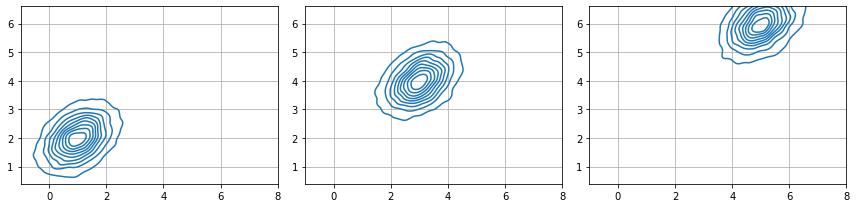

In [154]:
for ax,i in subplots(s.shape[1], usizex=4):    
    sns.kdeplot( x = s[:, i, 0], y = s[:, i, 1], ax=ax)
    plt.axis("equal"); plt.grid();
    plt.xlim(np.min(mu)-2, np.max(mu)+2)
    plt.ylim(np.min(mu)-4, np.max(mu)+4)
plt.tight_layout()

## Making sense of shapes

In general, samples from a distribution will have the shape `[sample_shape, batch_shape, event_shape]`

- `sample_shape` is determined when you call the `sample` method of the distribution
- `batch_shape` is determined by the parameters of the distribution when you create it
- `event_shape` is detemrined by the nature of the multivariate distribution you use


This way:

- **samples**: are independant identically distributed
- **batch components**: are independant and **NOT** identically distributed
- **event components**: are **NOT** independant and **NOT** identiclly distributed 

The following table might help make sense of this. It is based on [this post](https://bochang.me/blog/posts/pytorch-distributions/) and [this post](https://ericmjl.github.io/blog/2019/5/29/reasoning-about-shapes-and-probability-distributions/).



$$
\begin{array}{|c|c|c|c|l|}\hline
\textbf{sample shape}&\textbf{batch shape}&\textbf{event shape} & \textbf{distribution for samples}  \\\hline
\texttt{[2]}&\texttt{[]}  &\texttt{[]} & X_0, X_1 \overset{iid}{\sim} \mathcal{N}(\mu, \sigma)&\text{one single variable distribution}\\\hline
\texttt{[2]}&\texttt{[3]}  &\texttt{[]} & X_{0,0}, X_{1,0} \overset{iid}{\sim} \mathcal{N}(\mu_0, \sigma_0)&\text{three single variable distributions}\\
&&& X_{0,1}, X_{1,1} \overset{iid}{\sim} \mathcal{N}(\mu_1, \sigma_1)\\
&&& X_{0,2}, X_{1,2} \overset{iid}{\sim} \mathcal{N}(\mu_2, \sigma_2)\\\hline
\texttt{[2]}&\texttt{[]}  &\texttt{[4]} & \mathbf{X}_0, \mathbf{X}_1 \overset{iid}{\sim} \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma})\;\;\;\;\;\mathbf{X}_i\in\mathbb{R}^4&\text{one mutivariate distribution}\\\hline
\texttt{[2]}&\texttt{[3]}  &\texttt{[4]} & \mathbf{X}_{0,0}, \mathbf{X}_{1,0} \overset{iid}{\sim} \mathcal{N}(\boldsymbol{\mu}_0, \boldsymbol{\sigma}_0)\;\;\;\;\;\mathbf{X}_i\in\mathbb{R}^4&\text{three multivariate distributions}\\
&&& \mathbf{X}_{0,1}, \mathbf{X}_{1,1} \overset{iid}{\sim} \mathcal{N}(\boldsymbol{\mu}_1, \boldsymbol{\sigma}_1)\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\\
&&& \mathbf{X}_{0,2}, \mathbf{X}_{1,2} \overset{iid}{\sim} \mathcal{N}(\boldsymbol{\mu}_2, \boldsymbol{\sigma}_2)\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\\\hline
\end{array}
$$

observe how we deal with each case in the code below

In [31]:
# batch_shape=[], event_shape=[]

d = tfd.Normal(loc=0, scale=1)
print (d)
print (d.sample(2).numpy())


tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)
[ 0.75803363 -1.8501624 ]


In [51]:
# batch_shape=[3], event_shape=[]     implicitly with vector parameters

d = tfd.Normal(loc=[0,1,2], scale=1) # broadcasting on batch same for scale
print (d)
print (d.sample(2).numpy())

tfp.distributions.Normal("Normal", batch_shape=[3], event_shape=[], dtype=float32)
[[ 1.1833676  1.7853057  5.493244 ]
 [-1.2918025  2.284341   0.9959991]]


In [52]:
# batch_shape=[], event_shape=[4]        explicitly with a multivariate distribution

mu = np.random.random(4)*10-5
cov = np.random.random(size=(4,4))+.1    # will broadcast covariance matrix
cov = tf.linalg.cholesky(cov.dot(cov.T)) # ensures positive definite matrix

d = tfd.MultivariateNormalTriL(mu,cov)

print (d)
print (d.sample(2).numpy())

tfp.distributions.MultivariateNormalTriL("MultivariateNormalTriL", batch_shape=[], event_shape=[4], dtype=float64)
[[-4.94196295  4.54800186 -0.1223484  -2.39742009]
 [-6.22349008  2.51441253 -2.61423195 -3.71563902]]


In [43]:
# batch_shape=[3], event_shape=[4]

mu = np.random.random((3,4))*10-5

cov = np.random.random(size=(4,4))+.1    # will broadcast covariance matrix
cov = tf.linalg.cholesky(cov.dot(cov.T)) # ensures positive definite matrix

d = tfd.MultivariateNormalTriL(mu,cov)

print (d)
print (d.sample(2).numpy())

tfp.distributions.MultivariateNormalTriL("MultivariateNormalTriL", batch_shape=[3], event_shape=[4], dtype=float64)
[[[-5.1101803   0.8596026   3.06403109  2.1083541 ]
  [ 3.69974774 -3.93829998 -1.6255217   2.22765852]
  [ 3.32589202  2.69049452 -4.32719606  1.2584832 ]]

 [[-5.93515374  0.91773734  2.35591075  2.1539073 ]
  [ 6.17373777 -3.15403426 -0.98656476  2.23261819]
  [ 1.86732188  2.18168707 -5.64504685  1.01497814]]]


## The `Independent` distribution object

Allows us to transfer dimensions from `batch_shape` to `event_shape`.

This might be useful when designing specific final distributions. Recall that batches are sets of distributions of the same family but with different parameters, so they are **independant**, whereas events belong to the same multivariate and maybe dependant.


In [44]:
# Initialize a single 3-variate Gaussian.
mu = np.random.random(size=(3,4,2)).astype(np.float32)

cov = [[ 0.36,  0.12],
       [ 0.12,  0.29]]

mvn = tfd.MultivariateNormalTriL(
    loc=mu,
    scale_tril=tf.linalg.cholesky(cov)
)

mvn

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[3, 4] event_shape=[2] dtype=float32>

In [177]:
s = mvn.sample(100000)
s.shape

TensorShape([100000, 3, 4, 2])

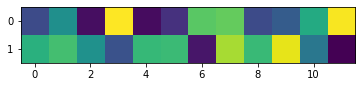

In [170]:
plt.imshow(np.mean(s, axis=0).reshape(2,-1))

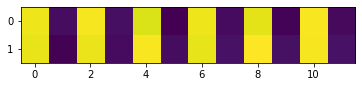

In [171]:
plt.imshow(np.std(s, axis=0).reshape(2,-1))

**redistribute dimensions**

In [45]:
mi = tfd.Independent(mvn, reinterpreted_batch_ndims=1)
mi

<tfp.distributions.Independent 'IndependentMultivariateNormalTriL' batch_shape=[3] event_shape=[4, 2] dtype=float32>

observe that samples have the same shape and individual distributions

In [46]:
s = mi.sample(100000)
s.shape

TensorShape([100000, 3, 4, 2])

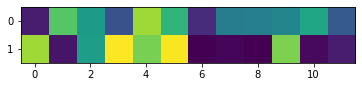

In [47]:
plt.imshow(np.mean(s, axis=0).reshape(2,-1))

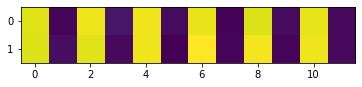

In [48]:
plt.imshow(np.std(s, axis=0).reshape(2,-1))